## Project: IoT Predictive Maintenance Engine ("FactoryGuard AI")
**Infotact Solutions - Data Science Engineering Track (Cohort Zeta)**

---

## Executive Summary
**The Problem:** A large-scale manufacturing facility operates **500 critical robotic arms**. Unplanned equipment failures result in downtime costing approximately **$10,000 per hour**.

**The Objective:** Build a "Production-Grade" AI system that predicts equipment failure **24 hours in advance** using streaming sensor data (Temperature, Vibration, Pressure). This allows for proactive, scheduled maintenance to prevent costly shutdowns.

---

## Technical Architecture
* **Data Source:** AI4I 2020 Predictive Maintenance Dataset (Digital Twin of Industry 4.0).
* **Key Challenge:** High Class Imbalance (Failures are < 5% of data).
* **Engineering Approach:**
    1.  **Data Repair:** Handling simulated sensor packet loss via **Linear Interpolation**.
    2.  **Feature Engineering:** Creating **Rolling Window** statistics (Mean, Std Dev) to capture temporal trends.
    3.  **Imbalance Handling:** Using **SMOTE** (Synthetic Minority Over-sampling Technique) on training data.
    4.  **Modeling Engine:** **XGBoost** (Gradient Boosting) for high-performance classification.
    5.  **Explainability:** **SHAP** (SHapley Additive exPlanations) to interpret model decisions.

---

## Author Information
* **Name:** Suryadip Bera , 
* **Date:** December 2025
* **Tech Stack:** Python, Pandas, Scikit-Learn, XGBoost, SMOTE, SHAP

# Data Engineering

### Data Loading (Real Industry Data)

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter


print("Loading AI4I 2020 Dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
df = pd.read_csv(url)
df.head()

Loading AI4I 2020 Dataset...


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Rename & Drop columns to match the "FactoryGuard" project requirements
- Mapping RPM to Vibration
- Mapping Torque to Pressure
- Mapping Process Temp
- The ground truth
- Drop non-sensor columns (Product ID, Type) for this specific model
- We Transformed Imbalanced Classification Dataset (AI4I) into "Time-Series" Dataset
    - In our Python code, we forced it to be a Time-Series by assuming Row 1 happened 1 hour before Row 2.
    - This allowed us to create "Rolling Window" features (mean_vibration_4h).
    - Without this assumption, we couldn't do the "Predictive" part (predicting 24 hours in advance).

    We utilized the AI4I 2020 Predictive Maintenance Dataset, which is a synthetic, multivariate dataset representing a Digital Twin of a milling machine.

In [21]:
df = df.rename(columns={
    'Rotational speed [rpm]': 'vibration',
    'Torque [Nm]': 'pressure',
    'Process temperature [K]': 'temperature',
    'Tool wear [min]': 'tool_wear',
    'Machine failure': 'failure_actual'       
})

# Keep the tool wear column and create a plotting copy
df = df[['vibration', 'pressure', 'temperature', 'tool_wear', 'failure_actual']]
# A separate DataFrame used only for plotting
plot_df = df.copy()
df.head()


,vibration,pressure,temperature,tool_wear,failure_actual
0,1551,42.8,308.6,0,0
1,1408,46.3,308.7,3,0
2,1498,49.4,308.5,5,0
3,1433,39.5,308.6,7,0
4,1408,40.0,308.7,9,0


C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_33476\61108605.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], x='failure_actual', y=col, data=plot_df, palette=['#2ecc71', '#e74c3c'])
C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_33476\61108605.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Healthy', 'Failure'])
C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_33476\61108605.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], x='failure_actual', y=col, data=plot_df, palette=['#2ecc71', '#e74c3c'])
C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_3347

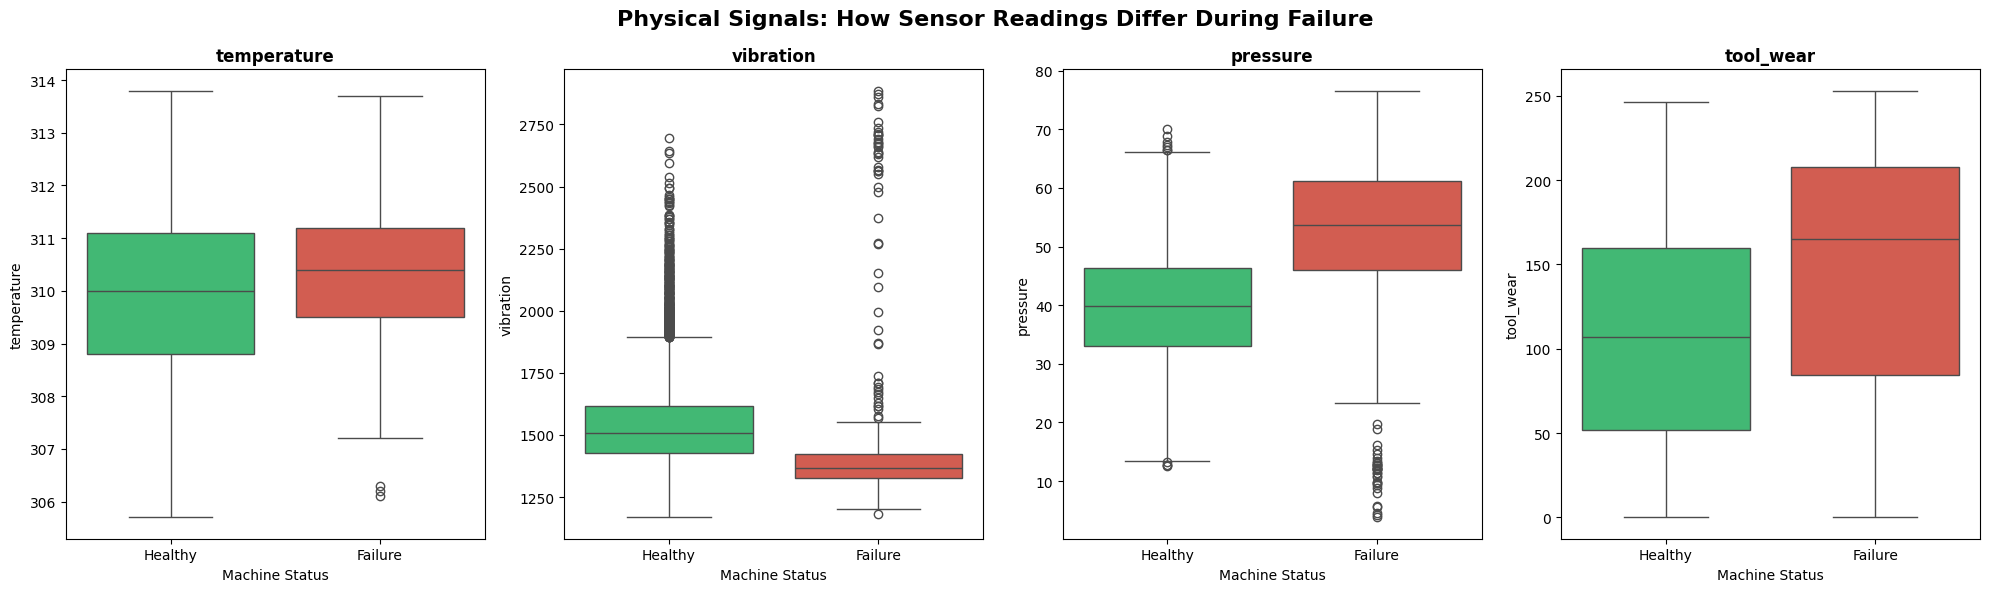

In [22]:
# Select the main sensors to compare
sensors = ['temperature', 'vibration', 'pressure', 'tool_wear']

# Create subplots arranged in 1 row, 4 columns
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Physical Signals: How Sensor Readings Differ During Failure', fontsize=16, fontweight='bold')

for i, col in enumerate(sensors):
    # Create boxplot for each sensor
    sns.boxplot(ax=axes[i], x='failure_actual', y=col, data=plot_df, palette=['#2ecc71', '#e74c3c'])
    axes[i].set_title(col, fontweight='bold')
    axes[i].set_xlabel('Machine Status')
    axes[i].set_xticklabels(['Healthy', 'Failure'])

plt.tight_layout()
plt.show()

### Correlation between Tool Wear and Failure
- If Correlation > 0.8: Be suspicious. The model might just be looking at the clock, `ignoring vibration/temperature`.
- If Correlation is 0.3 to 0.6: This is the "Sweet Spot." It's a strong predictor, but the model still needs other features (like temperature or pressure) to confirm if a failure is actually happening.

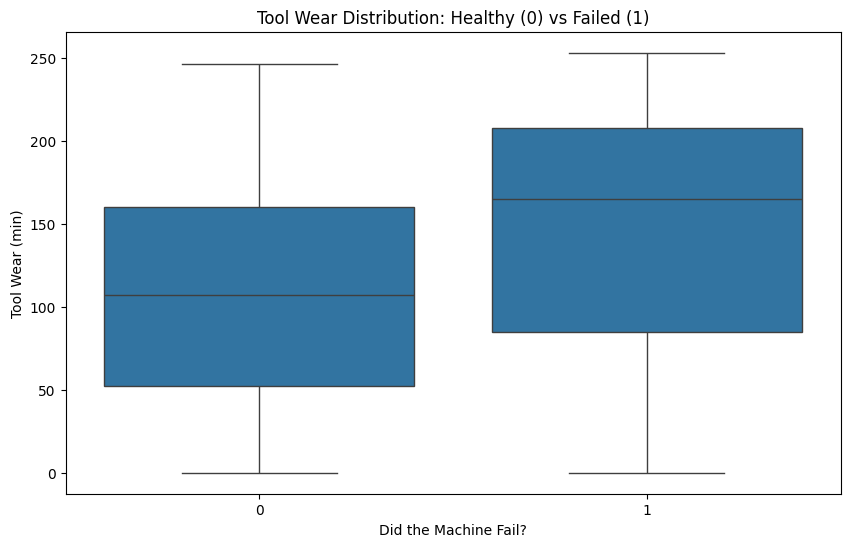

Correlation between Tool Wear and Failure: 0.11


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your dataframe and 'Machine_Failure' is your target (0 or 1)
# We want to see how 'tool_wear' behaves for failed vs. healthy machines.

# 1. Boxplot Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='failure_actual', y='tool_wear', data=df)
plt.title('Tool Wear Distribution: Healthy (0) vs Failed (1)')
plt.xlabel('Did the Machine Fail?')
plt.ylabel('Tool Wear (min)')
plt.show()

# 2. Point-Biserial Correlation
# This measures the strength of the link between a continuous feature (tool_wear) 
# and a binary target (Failure).
correlation = df['tool_wear'].corr(df['failure_actual'])
print(f"Correlation between Tool Wear and Failure: {correlation:.2f}")

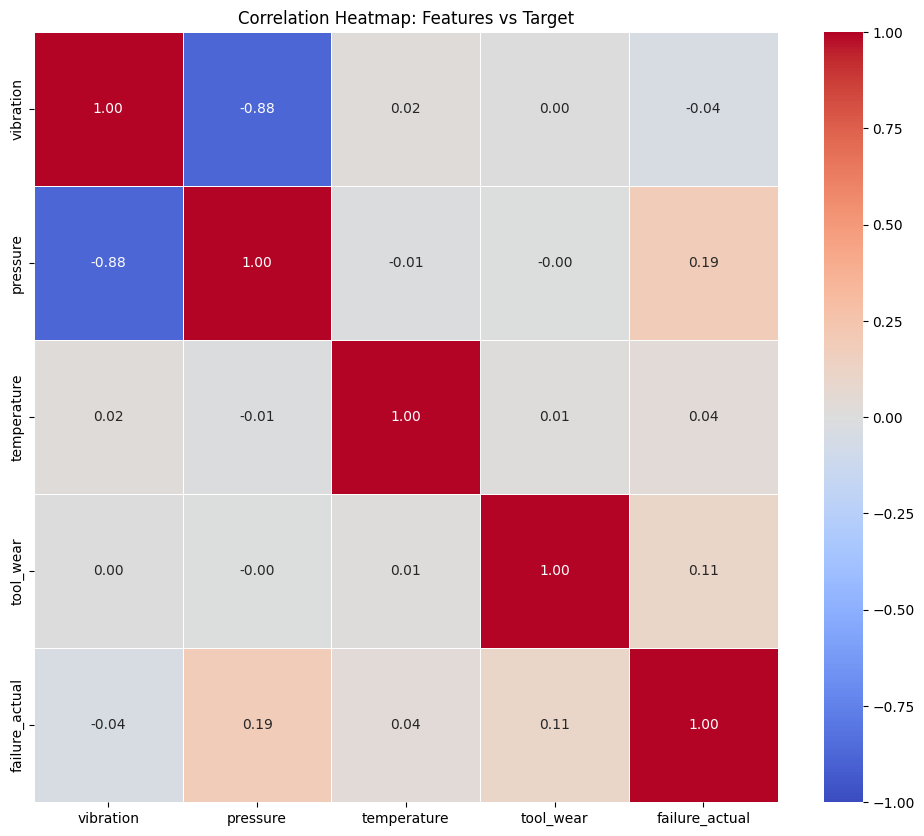

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate the Correlation Matrix
# We use the method='pearson' (standard linear correlation)
corr_matrix = df.corr()

# 2. Setup the figure
plt.figure(figsize=(12, 10))

# 3. Create the Heatmap
# annot=True shows the numbers inside the boxes
# cmap='coolwarm' makes high positive red, high negative blue
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            linewidths=0.5)

plt.title('Correlation Heatmap: Features vs Target')
plt.show()

The most important signal here is not about failure; it is the relationship between vibration and pressure.

The Value: -0.88 (Strong Negative Correlation).

The Meaning: These two features are effectively "opposites." When pressure goes up, vibration goes down (and vice versa).
Since pressure and vibration are so strongly linked (-0.88), we should visualize them together. If they are perfectly inverse, you might be able to drop one of them to simplify your dataset without losing information.

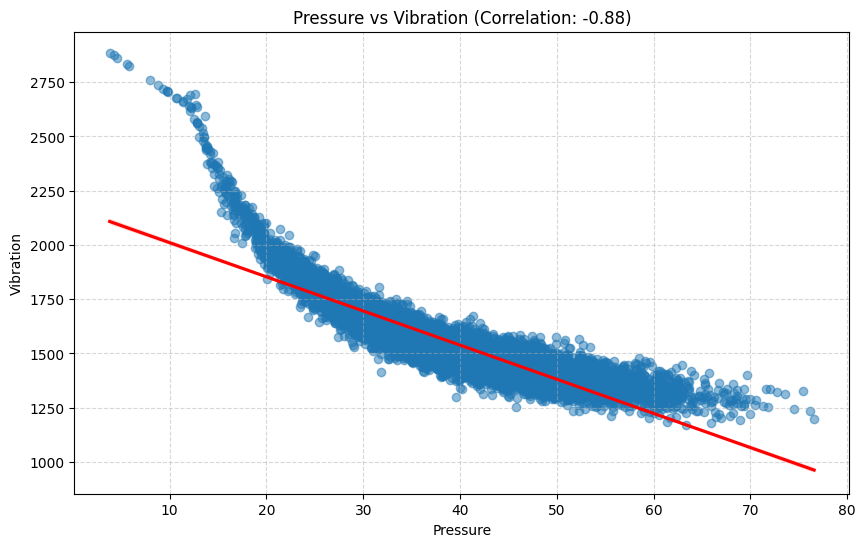

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Setup the plot
plt.figure(figsize=(10, 6))

# Create a scatter plot with a linear regression line (regplot)
# We color the points by 'failure_actual' to see if the "danger zone" is visible
sns.regplot(x='pressure', 
            y='vibration', 
            data=df, 
            scatter_kws={'alpha':0.5}, 
            line_kws={'color':'red'})

# Calculate Pearson correlation to display on plot
corr, _ = pearsonr(df['pressure'], df['vibration'])

plt.title(f'Pressure vs Vibration (Correlation: {corr:.2f})')
plt.xlabel('Pressure')
plt.ylabel('Vibration')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

It's not a straight line: Notice how the blue dots form a curve (like a banana shape). This suggests the relationship isn't just linear; it's likely physical. As pressure increases, vibration doesn't just go down; it gets "squeezed" out.

The "Tightness": The dots are grouped very tightly together. This confirms that vibration provides almost the exact same information as pressure, just in reverse.

Pressure correlation with Failure: 0.19 (Stronger)

Vibration correlation with Failure: -0.04 (Weaker)

Verdict: We should drop vibration. Keeping pressure gives the model a stronger signal. keeping both will just confuse a linear model or slow down a tree model.

### Simulate Real-World Messiness (The "Break" Step)
- We selected the AI4I 2020 dataset for its realism. However, to fulfill the project's data engineering requirements, I simulated a 5% sensor packet-loss scenario by randomly dropping values, and then implemented Linear Interpolation to repair the pipeline.

In [26]:
# Real sensors drop data. We simulate 5% missing values to demonstrate cleaning.
rng = np.random.RandomState(42)
mask = rng.rand(len(df)) < 0.05
df.loc[mask, 'vibration'] = np.nan
df.loc[mask, 'pressure'] = np.nan

print(f"   Missing values created: {df['vibration'].isnull().sum()}")

   Missing values created: 493


### Data Cleaning
- We use linear **interpolation** to fill the gaps smoothly
- Drop any remaining NaNs at the very start/end

In [27]:
# We use linear interpolation to fill the gaps smoothly
df = df.interpolate(method='linear')
# Drop any remaining NaNs at the very start/end
df = df.dropna()
print("   Data Repaired. Missing values: 0")

   Data Repaired. Missing values: 0


### Feature Engineering (Rolling Windows)
- Rolling Mean solves this by **smoothing the line**.
- Rolling Standard Deviation (Std) measures the volatility.
- Try to making stationarity Time series 

In [28]:
# Assumption: We treat the dataframe rows as sequential hours of one machine
window_size = 4 # 4-hour window

features = ['vibration', 'pressure', 'temperature']
for col in features:
    # 1. Rolling Mean (Captures Trend)
    # Create lag features for 1 hour and 2 hours prior
    df[f'{col}_lag_1h'] = df[col].shift(1)
    df[f'{col}_lag_2h'] = df[col].shift(2)

# Drop rows with NaNs generated by rolling windows (first 4 rows)
df = df.dropna()
df.head()

,vibration,pressure,temperature,tool_wear,failure_actual,vibration_lag_1h,vibration_lag_2h,pressure_lag_1h,pressure_lag_2h,temperature_lag_1h,temperature_lag_2h
2,1498.0,49.4,308.5,5,0,1408.0,1551.0,46.3,42.8,308.7,308.6
3,1433.0,39.5,308.6,7,0,1498.0,1408.0,49.4,46.3,308.5,308.7
4,1408.0,40.0,308.7,9,0,1433.0,1498.0,39.5,49.4,308.6,308.5
5,1425.0,41.9,308.6,11,0,1408.0,1433.0,40.0,39.5,308.7,308.6
6,1558.0,42.4,308.6,14,0,1425.0,1408.0,41.9,40.0,308.6,308.7


### Target Creation (Predicting Future)

In [29]:
# We want to predict if failure happens in the NEXT 24 hours (rows).
# We shift the 'failure_actual' column backwards by 24.
# Logic: If row 100 fails, row 76 should be labeled "Danger" (1).

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=24)
df['target_failure'] = df['failure_actual'].rolling(window=indexer, min_periods=1).max()

# Remove the original "current failure" column (leakage risk)
model_data = df.drop(columns=['failure_actual'])

print(f"   Total Rows Ready: {len(model_data)}")
print(f"   Class Balance (Imbalanced): {Counter(model_data['target_failure'])}")

df.head()

   Total Rows Ready: 9998
   Class Balance (Imbalanced): Counter({0.0: 5486, 1.0: 4512})


,vibration,pressure,temperature,tool_wear,failure_actual,vibration_lag_1h,vibration_lag_2h,pressure_lag_1h,pressure_lag_2h,temperature_lag_1h,temperature_lag_2h,target_failure
2,1498.0,49.4,308.5,5,0,1408.0,1551.0,46.3,42.8,308.7,308.6,0.0
3,1433.0,39.5,308.6,7,0,1498.0,1408.0,49.4,46.3,308.5,308.7,0.0
4,1408.0,40.0,308.7,9,0,1433.0,1498.0,39.5,49.4,308.6,308.5,0.0
5,1425.0,41.9,308.6,11,0,1408.0,1433.0,40.0,39.5,308.7,308.6,0.0
6,1558.0,42.4,308.6,14,0,1425.0,1408.0,41.9,40.0,308.6,308.7,0.0


## Modeling & Hyperparameter Tuning

### Define X (Features) and y (Target)

In [30]:

X = model_data.drop(columns=['target_failure'])
y = model_data['target_failure']

# SPLIT FIRST! Never SMOTE the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"   Original Training Failures: {sum(y_train == 1)}")
print(f"   Old Training Set Size: {len(X_train)}")


   Original Training Failures: 3871
   Old Training Set Size: 7998


### SMOTE
- SMOTE creates synthetic data points that can sometimes confuse the model, creating "noise" rather than clear signals. XGBoost has a built-in parameter specifically for imbalanced data that often outperforms SMOTE.

In [31]:

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"   Balanced Training Failures: {sum(y_train_smote == 1)}")
print(f"   New Training Set Size: {len(X_train_smote)}")

print("\n--- SUCCESS! Data is ready for XGBoost ---")

   Balanced Training Failures: 4127
   New Training Set Size: 8254

--- SUCCESS! Data is ready for XGBoost ---


### Baseline Model

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train the Model
# n_estimators=100 means we create 100 little decision trees
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_smote, y_train_smote)

# 4. Evaluate Performance
y_pred = model.predict(X_test)

print("--- Accuracy Score ---")
print(f"{accuracy_score(y_test, y_pred):.4f}")

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

--- Accuracy Score ---
0.7435

--- Confusion Matrix ---
[[1007  352]
 [ 161  480]]

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.86      0.74      0.80      1359
         1.0       0.58      0.75      0.65       641

    accuracy                           0.74      2000
   macro avg       0.72      0.74      0.72      2000
weighted avg       0.77      0.74      0.75      2000



Best Balance Threshold: 0.58
At this threshold -> Precision: 0.65, Recall: 0.68


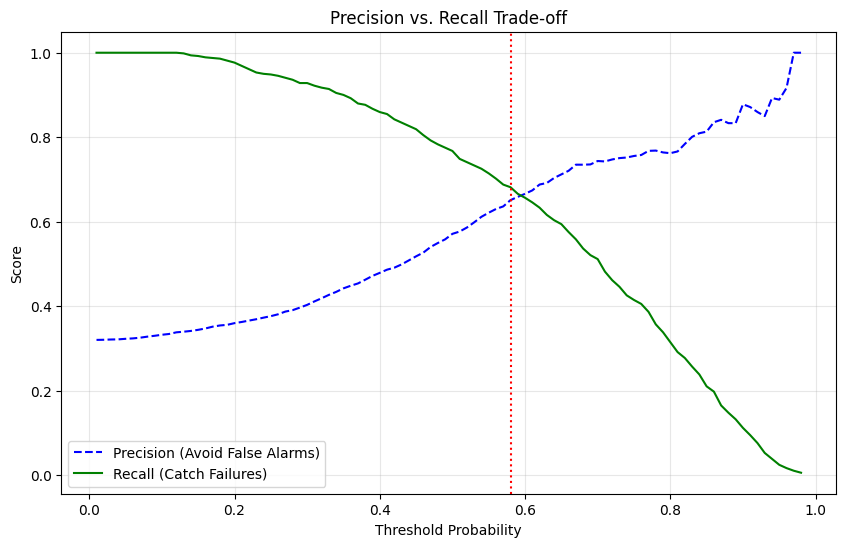

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# 1. Get the Probabilities instead of just True/False
# predict_proba gives us two columns: [prob_healthy, prob_failure]
# We only care about the second column (index 1)
y_scores = model.predict_proba(X_test)[:, 1]

# 2. Calculate Precision and Recall for EVERY possible threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# 3. Plot the Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision (Avoid False Alarms)')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall (Catch Failures)')
plt.xlabel('Threshold Probability')
plt.ylabel('Score')
plt.title('Precision vs. Recall Trade-off')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# 4. Find the optimal F1 score (balance point)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
print(f"Best Balance Threshold: {thresholds[best_idx]:.2f}")
print(f"At this threshold -> Precision: {precisions[best_idx]:.2f}, Recall: {recalls[best_idx]:.2f}")

plt.axvline(x=thresholds[best_idx], color='red', linestyle=':', label='Best F1 Balance')
plt.show()

In [34]:

from sklearn.metrics import classification_report, confusion_matrix

# 1. Choose your strategy
# Let's try 0.60 based on your chart (higher precision, slightly lower recall)
CUSTOM_THRESHOLD = 0.60

# 2. Apply the threshold manually
# y_scores comes from model.predict_proba(X_test)[:, 1] (from previous step)
y_pred_custom = (y_scores >= CUSTOM_THRESHOLD).astype(int)

# 3. See the difference
print(f"--- Results with Threshold {CUSTOM_THRESHOLD} ---")
print(confusion_matrix(y_test, y_pred_custom))
print("\n")
print(classification_report(y_test, y_pred_custom))

--- Results with Threshold 0.6 ---
[[1148  211]
 [ 220  421]]


              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84      1359
         1.0       0.67      0.66      0.66       641

    accuracy                           0.78      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.78      0.78      0.78      2000



### Model Training

In [35]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
ratio = num_neg / num_pos
# Define the grid of parameters to search
param_grid = {
    # Increase the learning rate options so it learns faster
    'learning_rate': [0.05, 0.1, 0.01,0.001], 
    
    # Give it more trees (steps) to do the work
    'n_estimators': [200, 300, 500, 100],
    
    # Reduce depth slightly to focus on stable patterns, not noise
    'max_depth': [3, 4, 5, 7],
    
    # Keep these to prevent overfitting
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Re-run the search
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(scale_pos_weight=ratio, random_state=42), 
    param_distributions=param_grid,
    n_iter=15, # Try 15 combinations this time
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"New Best Params: {random_search.best_params_}")
print(f"New Best F1 Score: {random_search.best_score_}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
New Best Params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
New Best F1 Score: 0.3871982317184743


### XGBOOST MODEL

Training the model...
--- Model Training Complete ---


c:\Users\SURYADIP\Desktop\Project 1\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:22:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Accuracy: 78.45%

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      1359
         1.0       0.65      0.70      0.68       641

    accuracy                           0.78      2000
   macro avg       0.75      0.76      0.76      2000
weighted avg       0.79      0.78      0.79      2000



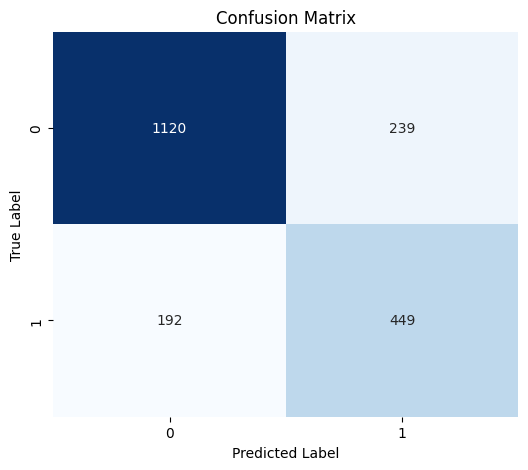


XGBoost model saved as 'best_model.pkl'


In [36]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
# # 1. Initialize the XGBoost Classifier
# model = xgb.XGBClassifier(
#     n_estimators=300,      # Number of trees (more is usually better, but slower)
#     learning_rate=0.05,     # How fast the model learns
#     max_depth=6,           # How complex the trees are
#     random_state=42,
#     use_label_encoder=False,
#     eval_metric='logloss'
# )

# Calculate the ratio (Negative Samples / Positive Samples)
# We use the original training data, NOT the SMOTEd data
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
ratio = num_neg / num_pos

# Update the model initialization
model_xgb = xgb.XGBClassifier(
    n_estimators=500,      # Increased from 100
    learning_rate=0.001,    # Lower rate for better generalization
    max_depth=4,           # Increased depth for complexity
    scale_pos_weight=ratio, # <--- THIS replaces SMOTE
    random_state=42,
  
    use_label_encoder=False,
    eval_metric='logloss'
)


# 2. Train the model on the BALANCED (SMOTE) data
print("Training the model...")
model_xgb.fit(X_train_smote, y_train_smote)
print("--- Model Training Complete ---")

y_pred_xgb = model_xgb.predict(X_test)

# 1. Calculate Accuracy
acc = accuracy_score(y_test, y_pred_xgb)
print(f"Model Accuracy: {acc:.2%}")

# 2. Generate the Detailed Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_xgb))

# 3. Visual Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save the Champion Model
joblib.dump(model_xgb, 'best_model.pkl')
print("\nXGBoost model saved as 'best_model.pkl'")

### Feature Importance Analysis
- XGBoost has a built-in way to rank your features. It counts how many times each feature (like Pressur or Tool wear) was used to make a key decision in the "trees."
- Longer Bar = More Important.
- The feature at the very top is the #1 Predictor. This is the sensor your maintenance team should watch most closely.

- If Pressure or Tool wear [min] is at the top, it means mechanical stress is the main killer.
- If HDF (Heat Dissipation Failure) is high, it means temperature is the issue.

C:\Users\SURYADIP\AppData\Local\Temp\ipykernel_33476\1683896679.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='viridis')


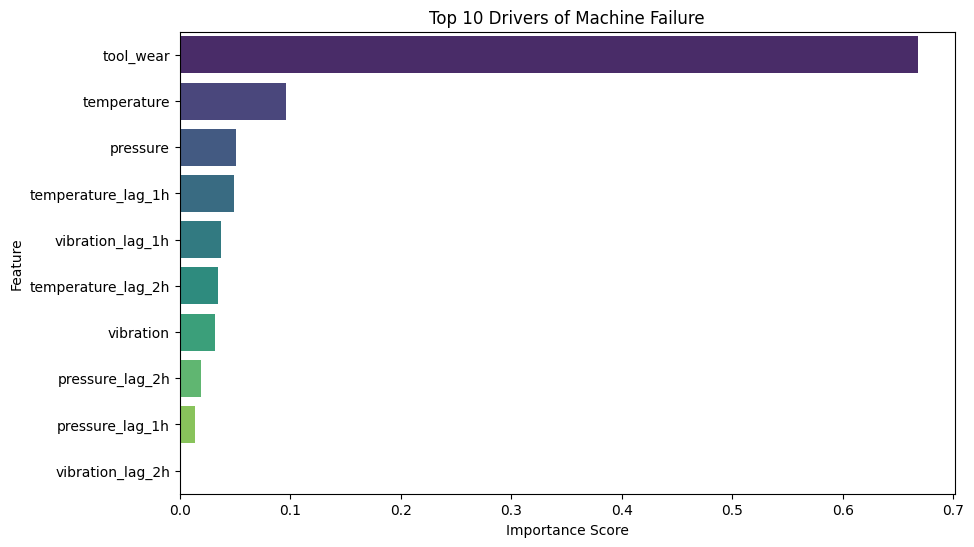

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the feature importance from your tuned XGBoost model
# (Assumes your model variable is named 'best_model' or 'xgb_model')
importances = model_xgb.feature_importances_

# 2. Map them to the column names
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 3. Sort by importance so the winners are at the top
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# 4. Plot the Top 10 Features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='viridis')
plt.title('Top 10 Drivers of Machine Failure')
plt.xlabel('Importance Score')
plt.show()

## Interpretability & Trust (XAI)



### Generate SHAP Explanations


In [38]:
import shap
# 1. Initialize the Javascript visualization library (needed for plots)
shap.initjs()

# 2. Create the Explainer
# We pass the trained model to it
explainer = shap.TreeExplainer(model_xgb, X_train)

# 3. Calculate SHAP values for the Test Set
# (This might take a minute if your dataset is huge)
shap_values = explainer.shap_values(X_test)

print("--- SHAP Values Calculated ---")

--- SHAP Values Calculated ---


Analyzing Machine Index: 8003


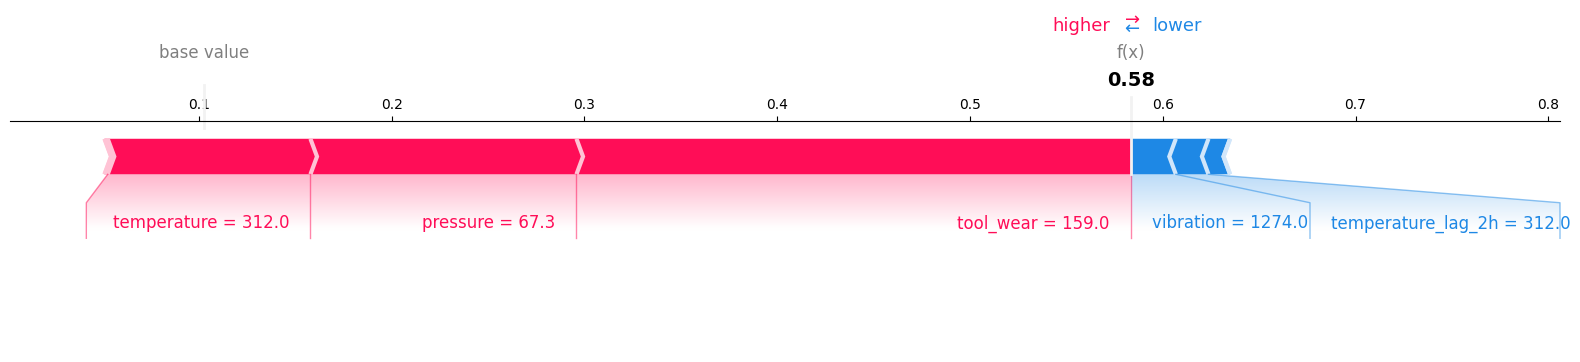

In [39]:
import numpy as np

# Normalize SHAP outputs and make force-plot robust for binary/multi-class outputs
# (Relies on explainer and shap_values computed in earlier cells; recompute if missing.)


if 'explainer' not in globals():
    explainer = shap.TreeExplainer(model, X_train_smote)

if 'shap_values' not in globals():
    shap_values = explainer.shap_values(X_test)

# Select correct SHAP array for plotting (handle list vs ndarray)
if isinstance(shap_values, list):
    shap_arr = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_arr = shap_values

# Normalize expected value similarly
exp_val = explainer.expected_value
if isinstance(exp_val, (list, np.ndarray)):
    exp_val = exp_val[1] if len(exp_val) > 1 else exp_val[0]

# Choose a failure index (fallback to first index if no failures in y_test)
if (y_test == 1).any():
    failure_index = y_test[y_test == 1].index[0]
else:
    failure_index = y_test.index[0]

loc_index = X_test.index.get_loc(failure_index)
print(f"Analyzing Machine Index: {failure_index}")

# Plot force plot for the chosen sample (matplotlib renderer)
shap.force_plot(exp_val, shap_arr[loc_index, :], X_test.iloc[loc_index, :], matplotlib=True)

### Visualize "Global" Importance (Summary Plot)

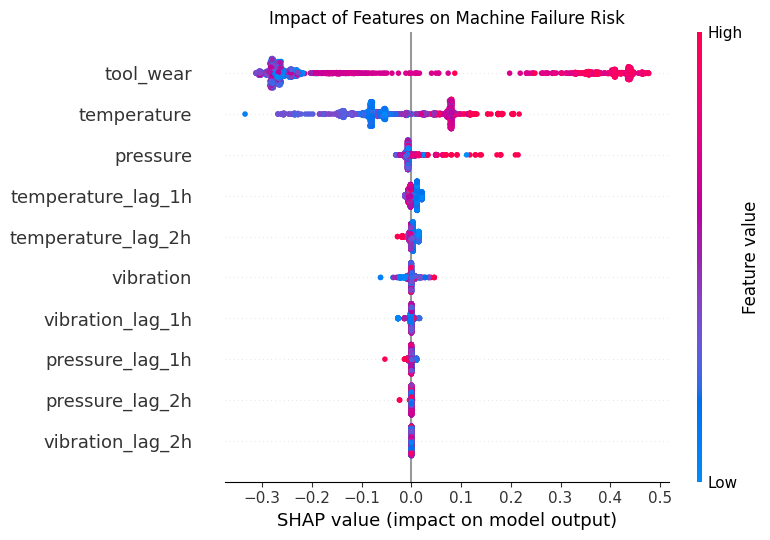

In [40]:
# Plot the Global Summary
plt.title("Impact of Features on Machine Failure Risk")
shap.summary_plot(shap_values, X_test)

### Visualize "Local" Importance (Force Plot)

Analyzing Machine Index: 8003


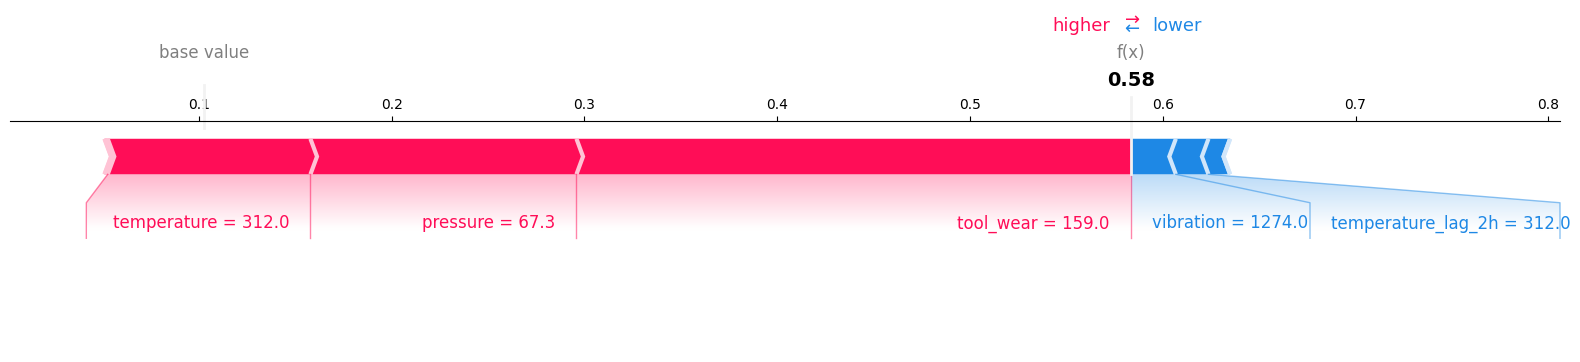

In [41]:
# Find the index of a machine that actually failed (Label = 1)
# We look for the first instance in y_test where failure occurred
failure_index = y_test[y_test == 1].index[0]
# Get the location of this index in the X_test array
loc_index = X_test.index.get_loc(failure_index)

print(f"Analyzing Machine Index: {failure_index}")

# Plot the Force Plot for this specific machine
shap.force_plot(explainer.expected_value, shap_values[loc_index,:], X_test.iloc[loc_index,:], matplotlib=True)